# 8章 Attention

In [14]:
import numpy as np

T, H = 5, 4
hs = np.random.randn(T, H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

ar = a.reshape(5, 1).repeat(4, axis=1)
print(ar.shape)

t = hs * ar
print(t.shape)

c = np.sum(t, axis=0)
print(c.shape)

(5, 4)
(5, 4)
(4,)


In [17]:
N, T, H =10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)
ar = a.reshape(N, T, 1).repeat(H, axis=2)
# ar = a.reshape(N, T, 1) # ブロードキャストを使う場合

t = hs * ar
print(t.shape)

c = np.sum(t, axis=1)
print(c.shape)

(10, 5, 4)
(10, 4)


In [57]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
    
    def forward(self, hs, a):
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1).repeat(H, axis=2)
        t = hs * ar
        c = np.sum(t, axis=1)

        self.cache = (hs, ar)
        return c
    
    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape

        dt = dc.reshape(N, 1, H).repeat(T, axis=1) # sumの逆伝播
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2) # repeatの逆伝播

        return dhs, da

In [19]:
import sys
sys.path.append('..')
from common.layers import Softmax

N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
h = np.random.randn(N, H)
hr = h.reshape(N, 1, H).repeat(T, axis=1)
# hr = h.reshape(N, 1, H) # ブロードキャストの場合

t = hs * hr
print(t.shape)

s = np.sum(t, axis=2)
print(s.shape)

softmax = Softmax()
a = softmax.forward(s)
print(a.shape)

(10, 5, 4)
(10, 5)
(10, 5)


In [20]:
class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None
    
    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H).repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a
    
    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh

In [21]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_Layer = WeightSum()
        self.attention_weight = None
    
    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_Layer.forward(hs, a)
        self.attention_weight = a
        return out
    
    def backward(self, dout):
        dhs0, da = self.weight_sum_Layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

In [22]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None
    
    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)
        
        return out
    
    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:, t, :] = dh
        
        return dhs_enc, dhs_dec
        dhs0, da = self.weight_sum_Layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

In [24]:
from common.time_layers import *

class AttentionEncoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs
    
    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

In [60]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def forward(self, xs, enc_hs):
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)

        return score
    
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:, :, :H], dout[:, :, H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs
    
    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

In [51]:
from common.base_model import BaseModel

class AttentionSeq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads
    
    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout
    
    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

In [61]:
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

# データの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 入力文を反転
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

model.save_params()

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 12[s] | loss 3.09
| epoch 1 |  iter 41 / 351 | time 25[s] | loss 1.90
| epoch 1 |  iter 61 / 351 | time 37[s] | loss 1.72
| epoch 1 |  iter 81 / 351 | time 48[s] | loss 1.46
| epoch 1 |  iter 101 / 351 | time 60[s] | loss 1.19
| epoch 1 |  iter 121 / 351 | time 72[s] | loss 1.14
| epoch 1 |  iter 141 / 351 | time 83[s] | loss 1.09
| epoch 1 |  iter 161 / 351 | time 95[s] | loss 1.06
| epoch 1 |  iter 181 / 351 | time 106[s] | loss 1.04
| epoch 1 |  iter 201 / 351 | time 117[s] | loss 1.03
| epoch 1 |  iter 221 / 351 | time 129[s] | loss 1.02
| epoch 1 |  iter 241 / 351 | time 140[s] | loss 1.02
| epoch 1 |  iter 261 / 351 | time 151[s] | loss 1.01
| epoch 1 |  iter 281 / 351 | time 163[s] | loss 1.00
| epoch 1 |  iter 301 / 351 | time 174[s] | loss 1.00
| epoch 1 |  iter 321 / 351 | time 186[s] | loss 1.00
| epoch 1 |  iter 341 / 351 | time 198[s] | loss 1.00
Q 10/15/94                     
T 1994-10-15

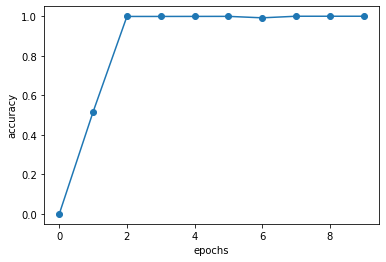

In [62]:
import matplotlib.pyplot as plt

# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(-0.05, 1.05)
plt.show()

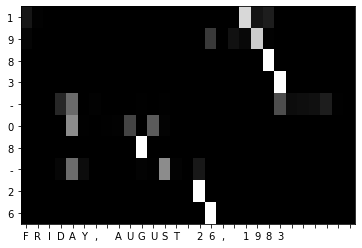

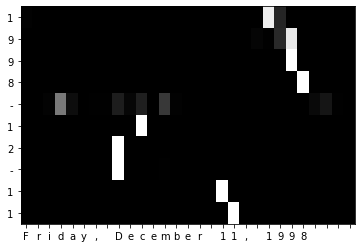

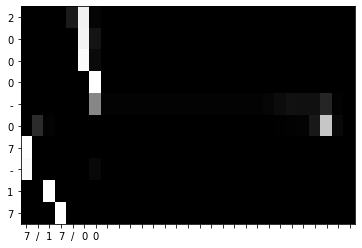

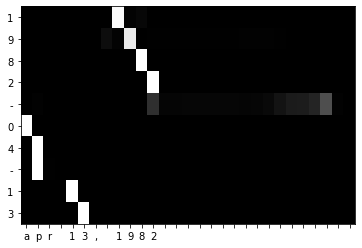

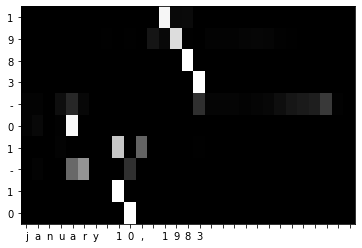

In [63]:
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse input
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # reverse for print
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)